# <span style="color:red">Solutions to Exam 2<span>

## Financial Analytics

### UChicago ADSP

#### Spring 2024
* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Time
* You have 90 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Submission
* You will upload your solution to the Exam "assignment" on Canvas.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:

#### Section 2
* New file: `data/option_data_AAPL.xlsx`
* New file: `data/exam_2_btc_futures.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 35     |
| 2       | 30     |
| 3       | 20     |
| **Total**   | **85**|

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1 Equity Options

Use the data in `data/option_data_AAPL.xlsx`.

Where needed, use the options prices reported in `lastPrice`, (rather than `bid` or `ask`.)

### 1.1
Consider the `AAPL` options expiring on `2024-05-17`, and $\tau$, can be rounded to be exactly `10/252` years.
* Compare $c-p$ to $S-K$ and $S-K^*$.

Answer the following
* What model or logic implies that these calculations are related? 
* What would change about this comparison if we assumed `AAPL` pays a dividend tomorrow?

(Going forward, assume `AAPL` does not pay a dividend within the timeframe we are considering.)

### 1.2
Assume that options are American and will be exercised immediately.

* Is the call-put spread priced too high or too low?

* How you could trade the difference. Be specific.

### 1.3

Chart the strike (horizontal axis) against the implied volatility (vertical axis) as indicated by the `2024-05-17` options reported in `call chain` and `put chain`.

What should we understand from the shape of this graph about...

* the Black-Scholes model?
* investor preferences?

### 1.4

Calculate the implied volatility of the `2024-05-17` calls struck at `180`. 

Should this implied volatility match the historic volatility of the stock? Why or why not?

### 1.5

For the `2024-05-17` put struck at `180`, report the following:
* delta
* gamma
* theta 

### 1.6
Suppose you **are short** options expiring `2024-05-17`...
* 3 puts struck at `170`
* 3 calls struck at `190`

Plot the price of `AAPL` versus the final NET payoff (or cost) of these options. 
* The net payoff will subtract the cost of buying the options.

Someone holding this position is hoping for what kind of `AAPL` movement?

### 1.7

Suppose you go long an `AAPL` call while also shorting $N$ shares of `AAPL` stock, where $N$ equals the delta of the call option.

Explain what is meant by the "gamma" of this position.

***

# <span style="color:red">Solutions</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from options import *
from portfolio import maximumDrawdown

## <span style="color:red">Load Data</span>

In [2]:
LOADFILE = '../data/option_data_AAPL.xlsx'

SHEET = 'market data'

mkt = pd.read_excel(LOADFILE,sheet_name=SHEET)
mkt = mkt.rename(columns={'Unnamed: 0':''}).set_index('')
mkt

,data
,
ticker,AAPL
equity price,181.710007
Tbill,0.0531
date,2024-05-06
option expiration,2024-05-17


In [3]:
SHEET = 'call chain'
calls = pd.read_excel(LOADFILE,sheet_name=SHEET).set_index('contractSymbol')

SHEET = 'put chain'
puts = pd.read_excel(LOADFILE,sheet_name=SHEET).set_index('contractSymbol')

SHEET = 'expirations'
expirations = pd.read_excel(LOADFILE,sheet_name=SHEET).set_index('expirations')

In [4]:
PRICEFLD = 'lastPrice'

## <span style="color:red">Solution 1</span>

### <span style="color:red">1.1</span>

In [5]:
STRIKE = 180

In [6]:
idCall = calls['strike']==STRIKE
c = calls[idCall][PRICEFLD].values[0]

idPut = puts['strike']==STRIKE
p = puts[idPut][PRICEFLD].values[0]

S = mkt.loc['equity price','data']
r = mkt.loc['Tbill','data']

# if want to calculate it programatically, here it is
t = mkt.loc['date','data']
T = mkt.loc['option expiration','data']
DAYSYEAR = 365.25
days_to_exp = (datetime.datetime.strptime(T,'%Y-%m-%d') - datetime.datetime.strptime(t,'%Y-%m-%d')).days
tau = days_to_exp / DAYSYEAR

# set tau according to instruction
tau = 10/252

In [7]:
putcall = pd.DataFrame([c-p, S-STRIKE, S - STRIKE * np.exp(-r*tau)],index=['c-p','S-K','S-K*'],columns=[''])
putcall.style.format('${:.4f}')

,
c-p,$1.7600
S-K,$1.7100
S-K*,$2.0889


where $K^*$ denotes $Ke^{-r\tau}$.

* This relationship is based on the logic that we can replicate the stock with a call, put, and cash. This is known as **put-call parity** which is a no-arbitrage condition. 

* The replicated position (using $c-p$) will not pay a dividend and will thus have lower value than $S-K$.

### <span style="color:red">1.2</span>

We see that the call-put spread is **bigger** than the share-strike spread, $S-K$.

(Recall that we are assuming immediate exercise and comparing to $K$ rather than $K^*$.

Thus, we would want to go 
* short the call-minus-put
* long the stock-minus-cash

In other words...
* short call plus long put short cash equal to present value of strike price
* long the share of stock

Then
* replicated the (short) share of stock for a price of $-c+p-+K$
* long a share $S$

At expiration,
* replicated position exactly matches $S$ no matter what happens to $S$.
* total profit is $(c-p+K) - S = c-p - (S-K)$

In [8]:
profit = (putcall.loc['c-p'] - putcall.loc['S-K']).to_frame().rename(columns={0:'pnl'})
profit.style.format('${:.2f}')

,pnl
,$0.05


### <span style="color:red">1.3</span>

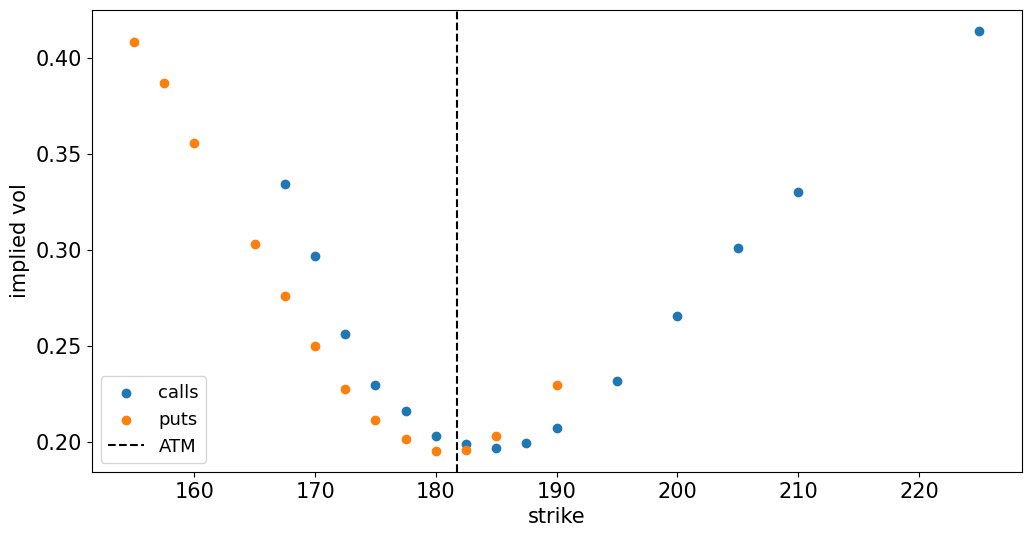

In [9]:
plt.scatter(calls['strike'],calls['impliedVolatility'],label='calls')
plt.scatter(puts['strike'],puts['impliedVolatility'],label='puts')
plt.axvline(x=S, color='black', linestyle='--', label='ATM')
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.legend()
plt.show()

The chart of the so-called "volatility smile" indicates that...
* Black-Scholes doesn't hold perfectly, as it assumes one vol (strictly across all strikes or at least the same vol at a strike for puts and calls)
* investors prefer options that pay off in the tails as exhibited by their higher implied vols deeply in or out of the money. 

### <span style="color:red">1.4</span>

In [10]:
ivol_quote = calls[idCall]['impliedVolatility'].values[0]
ivol_calc = bs_impvol(S,STRIKE,tau,r,option='call',opt_price=c)[0]
pd.DataFrame([ivol_quote,ivol_calc],index=['quote','estimated'],columns=['implied volatility']).style.format('{:.2%}')

,implied volatility
quote,20.31%
estimated,16.44%


No, the implied vol will not match the historic vol. Implied vol is a measure that looks ahead at vol over the remaining life of the option, not looking back at the historic vol. 

Furthermore, as discussed, the implied vol is distorted by investor risk aversion and preferences.

### <span style="color:red">1.5</span>

Calculating the greeks requires using the implied volatility of the option.

As we saw in the previous problem, there is a difference between the quoted and calculated implied volatilities.

**Feel free to use either, as the question did not specify.**

In [11]:
IVOL = ivol_quote

greeks = pd.DataFrame([
    bs_delta(S,STRIKE,tau,r,IVOL),
    bs_gamma(S,STRIKE,tau,r,IVOL),
    bs_theta(S,STRIKE,tau,r,IVOL)],
    index=['delta','gamma','theta'], columns=['quoted ivol'])

IVOL = ivol_calc
greeks['estimated ivol'] = [bs_delta(S,STRIKE,tau,r,IVOL),bs_gamma(S,STRIKE,tau,r,IVOL),bs_theta(S,STRIKE,tau,r,IVOL)]

greeks.style.format('{:.4f}')

,quoted ivol,estimated ivol
delta,0.6202,0.6441
gamma,0.0518,0.0626
theta,-41.0379,-33.9617


### <span style="color:red">1.6</span>

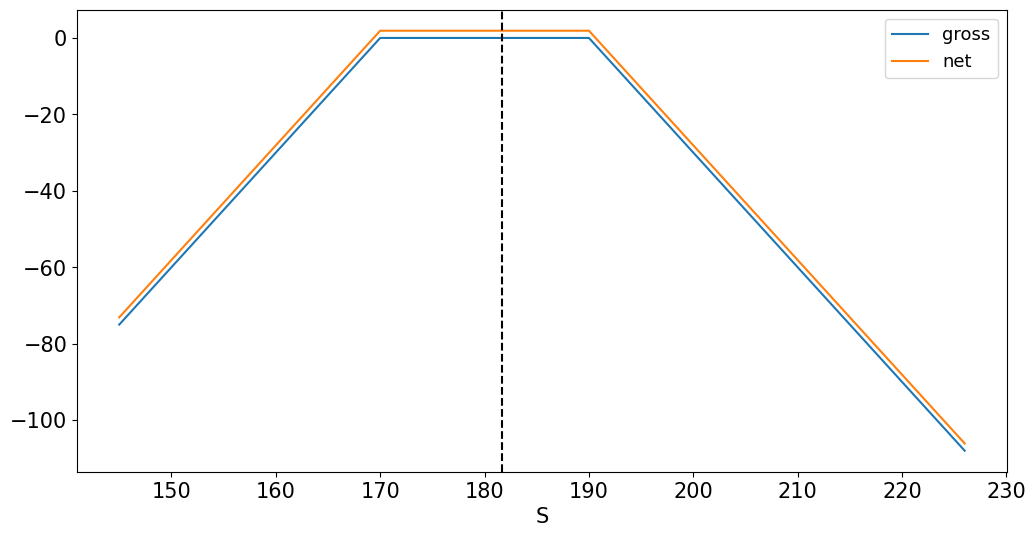

In [12]:
STRIKE_UP = 190
STRIKE_DOWN = 170
Nc = -3
Np = -3

c_up = calls[calls['strike']==STRIKE_UP][PRICEFLD].values[0]
p_down = puts[puts['strike']==STRIKE_DOWN][PRICEFLD].values[0]

stock_values = range(round(S*4/5), round(S*5/4))

df = pd.DataFrame({'S': stock_values})
df['gross'] = Nc * np.maximum(df['S']-STRIKE_UP,0) + Np * np.maximum(STRIKE_DOWN-df['S'],0)
df['net'] = df['gross'] - Nc * c_up - Np * p_down
df = df.set_index('S')

ax = df.plot()
plt.axvline(x=S, color='black', linestyle='--', label='Stock')
plt.show()

In [13]:
payoff_min = df['net'].max()
display(f'The net payoff if the stock stays between the two strikes is ${payoff_min:.2f}.')

'The net payoff if the stock stays between the two strikes is $1.89.'

The strategy is betting on the stock staying inside a narrow range. Otherwise, the strategy could lose big.

***

# 2. Futures Contracts

The data in the `price` tab of `exam_2_btc_futures.xlsx` gives a small sample of price data on two different futures contracts.

Both contracts are for `BTC`, bitcoin.

Consider a strategy of 
* buying **1** front contract at the end of `2024-04-22`.
* rolling it, (still one contract,) at the end of `2024-04-25`.
* exiting your position at the end of `2024-04-30`.

The contract size is `5`, so even for one contract, the contract price is `5x` the price shown in the series.

### 2.1

Report the 
* daily profit (loss) throughout the trade.
* total profit

### 2.2

Based on this short sample, (no need to look at further data,) would you conclude that `BTC` is in backwardation or contango? Explain your reasoning.

### 2.3

What economic reasons might explain this backwardation or contango for `BTC`?

### 2.4

Regardless of your answers above, suppose that today we observe the BTC futures curve in steep contango over the next year. What trade would you suggest putting on to profit from this?

### 2.5

Suppose that instead you had a **continuous** futures series, (`BTC1`), which reports the price of the front contract on any given day. You naively take the day-over-day difference of this series to calculate a history of profit (loss) to holding bitcoin.

Do you suspect it would underreport or overreport the profits of holding bitcoin? Why?

### 2.6

For futures contracts written on securities (such as Bitcoin or the S&P500) what is a pragmatic reason that traders may prefer trading the future contract of a security rather than the security itself?

While many answers may be relevant, focus on the issue most discussed in class.

***

# <span style="color:red">Solution 2</span>

In [14]:
FILE = '../data/exam_2_btc_futures.xlsx'
SHEET_FUT = 'price'
fut = pd.read_excel(FILE,sheet_name=SHEET_FUT).set_index('date')
fut.style.format_index(lambda s: s.strftime('%Y-%m-%d')).format('{:.2f}',na_rep='')

,BTCJ4,BTCK4
date,,
2024-04-22,66610.00,67355.00
2024-04-23,66435.00,67155.00
2024-04-24,63880.00,64490.00
2024-04-25,64700.00,65270.00
2024-04-26,,64300.00
2024-04-29,,63450.00
2024-04-30,,59400.00


## <span style="color:red">2.1</span>

The intention is that on the day of the contract expiration you
* sell out of the expiring contract
* buy into the next contract

Thus, on Jan 20, you realize a profit on CLG3 and invest into a single contract of CLJ3.
* We are not considering the difference between CLG3 and CLJ3 (the roll) as a profit or loss on Jan 20.
* Rather, we are considering the pnl as the day-over-day differences on a single contract. The money invested to change contracts is treated here as an additional capital expenditure.

And on Jan 21, you realize a profit on CLJ3, as you bought into this contract on Jan 20.

In [15]:
SIZE = 5

pnl = fut.diff()
contracts = pnl.isna().idxmin(axis=1)

stackroll = pd.DataFrame([pnl.loc[dt,contracts.loc[dt]] for dt in pnl.index], index=pnl.index, columns=['pnl'])

futpnl = pd.concat([fut,stackroll],axis=1)
futpnl.style.format_index(lambda s: s.strftime('%Y-%m-%d')).format('{:,.0f}',na_rep='')

,BTCJ4,BTCK4,pnl
date,,,
2024-04-22,"66,610","67,355",
2024-04-23,"66,435","67,155",-175
2024-04-24,"63,880","64,490","-2,555"
2024-04-25,"64,700","65,270",820
2024-04-26,,"64,300",-970
2024-04-29,,"63,450",-850
2024-04-30,,"59,400","-4,050"


In [16]:
rollprofits = stackroll.sum().values[0]
print(f'Total profit, not counting roll, is ${rollprofits:,.2f}.')

Total profit, not counting roll, is $-7,780.00.


#### <span style="color:red">Alternate</span>

If you counted the extra capital needed on `2024-04-25` to roll as a profit/loss instead of reallocation of capital, then your pnl on the roll date would be adjusted by the roll spread.
* Though again, we've talked about the fact that this is less of a typical pnl and more of a reallocation of capital from one type of contract to another, similar to moving money out of one stock and into another.

Note that in any accounting, it would be wrong to consider the roll up (via contango) as a profit!

In [17]:
stackroll_alt = stackroll.copy()
# careful this calculation assumes the problem is rolling a single time, (as in this example)
idx = fut.iloc[:,0].last_valid_index()
stackroll_alt.loc[idx] += -fut.loc[idx].diff()[1]
futpnl['alt pnl'] = stackroll_alt
futpnl.style.format_index(lambda s: s.strftime('%Y-%m-%d')).format('{:,.0f}',na_rep='')

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_82084/2865362328.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stackroll_alt.loc[idx] += -fut.loc[idx].diff()[1]


,BTCJ4,BTCK4,pnl,alt pnl
date,,,,
2024-04-22,"66,610","67,355",,
2024-04-23,"66,435","67,155",-175,-175
2024-04-24,"63,880","64,490","-2,555","-2,555"
2024-04-25,"64,700","65,270",820,250
2024-04-26,,"64,300",-970,-970
2024-04-29,,"63,450",-850,-850
2024-04-30,,"59,400","-4,050","-4,050"


In [18]:
rollprofits_alt = stackroll_alt.sum().values[0]
print(f'Total profit, yes counting roll, is ${rollprofits_alt:,.2f}.')

Total profit, yes counting roll, is $-8,350.00.


## <span style="color:red">2.2</span>

On every day for which we have data on two contracts, the back contract is `more expensive`. 

This is evidence of `contango`, which refers to when the long-maturity futures contracts are `more expensive` than the short-maturity contracts.

In [19]:
fut.diff(axis=1).iloc[:,-1].to_frame('contango')

,contango
date,
2024-04-22,745.0
2024-04-23,720.0
2024-04-24,610.0
2024-04-25,570.0
2024-04-26,NaN
2024-04-29,NaN
2024-04-30,NaN


## <span style="color:red">2.3</span>

Given the contango, we would expect that there is a positive cost of carry causing the long-dated contracts to be more expensive. 

This seems true here: one has to forgo other uses of capital to hold BTC, whereas no capital is needed to hold the BTC futures contract. Thus, the holder of the futures contract must pay extra for longer-dated contracts.

## <span style="color:red">2.4</span>

We should...
* short the futures contracts today
* long 5 BTC spot now

At the future contract expiration, sell the 5 BTC at the going rate, and deliver the cash from the sell.

This is guaranteed to make a profit of the futures price minus the spot price. This trade is so obvious, we expect markets have already implemented it such that the spread between futures BTC and spot BTC is roughly the common rate of interest on this use of capital.

## <span style="color:red">2.5</span>

Given the observed contango of crude in our (short) sample, the continuous series would overestimate the profit.

The reason is that at each contract roll, the continuous series will show the price going up, but it is due to the roll, not due to profit.

## <span style="color:red">2.6</span>

There are many...
* efficient use of capital.
    * futures contracts require only a margin, allowing the trader to (in a sense) leverage the position.
* discrepancies between the spot market and the futures contract
* frictions of holding the underlying asset
    * BTC is a good example of this. Many institutions do not have a clear way to hold BTC but can hold BTC futures. (No need to deal with custodial issues, keys, etc.)


***

# 3. Miscellaneous

### 1.

Calculate the YTM of the US Treasury with the following parameters:

* time-to-maturity is 2 years
* coupon is 0.75% per year
* price is 92.11

What coupon amount would be required for this treasury to have a price above 100?

### 2. (10 pts)

Use the data in `data/equity_data.xlsx`, in the tab, `prices AAPL`.

Calculate the maximum drawdown of AAPL returns over this time.

Comment on whether you are using the adjusted or unadjusted return series, and why.

### 3.

Below is a picture of a perfectly delta-hedged option position.

Given that it has non-negative value for every underlying stock value, why doesn't everyone hold this position?

![](../refs/delta_hedge_midterm.png)

***

# <span style="color:red">Solution 3</span>

## <span style="color:red">3.1</span>

Immediately we know that the coupon necessary to price the bond above 100 (par) is a coupon greater than the YTM.

Calculate the YTM as usual...

In [20]:
from scipy.optimize import fsolve

def price_bond(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        accr_frac = (T-round(T))*cpnfreq
    
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price

def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    pv_wrapper = lambda y: price - price_bond(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)
    ytm = fsolve(pv_wrapper,.01)
    return ytm

In [21]:
PRICE = 92.11
T = 2
cpn = .0075
y = ytm(PRICE,T,cpn)[0]

bond_metrics = pd.DataFrame([T,cpn,PRICE,y],index=['time to maturity','coupon rate','price','ytm'],columns=['']).T
bond_metrics.style.format({'time to maturity':'{:.2f}','price':'{:.2f}','coupon rate':'{:.2%}','ytm':'{:.2%}'})

,time to maturity,coupon rate,price,ytm
,2.00,0.75%,92.11,4.94%


## <span style="color:red">3.2</span>

In [22]:
FILEIN = '../data/equity_data.xlsx'
SHEET = 'prices AAPL'
data_apple = pd.read_excel(FILEIN,sheet_name=SHEET).set_index('date')
KEY = 'Adjusted Price'
rAPPL = data_apple[[KEY]].pct_change()

maximumDrawdown(rAPPL)

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
Adjusted Price,-0.608739,2007-12-28,2009-01-20,2009-10-21,663 days


We use `Adjusted Prices` to give an accurate measure of returns to holding `AAPL`.

Otherwise, splits will give a misleading measure of returns. And dividends will be unaccounted.

## <span style="color:red">3.3</span>

This position is perfectly delta hedged and has positive gamma. Thus, it has a non-negative payoff for any underlying value.

But that is holding time constant! This plot is just an instant, and it misses this time dynamic.

In reality, time is passing, making the option get closser to expiration, which decreases its value. This negative **theta** will pull down the value of the option.

Thus, holding this position is a bet as to whether the underlying will move enough to earn enough profit (via gamma) to more than offset the loss due to theata.

***